In [1]:
import sys
sys.path.append("../")

In [2]:
from compert.train import train_compert
from compert.data import load_dataset_splits
from compert.plotting import CompertVisuals, ComPertHistory
from compert.api import ComPertAPI, get_reference_from_combo
import pandas as pd
import compert.plotting as pl
import pandas as pd
import numpy as np


In [3]:
from os import listdir
from os.path import isfile, join
from os import walk

mypath = '../pretrained_models/'
_, folders, _ = next(walk(mypath))
for fold in folders:
    for f in listdir(join(mypath, fold)):
        if 'cross' in f:
            print(join(mypath, fold, f))

../pretrained_models/cross_species/sweep_cross_species_new_split3_model_seed=8_epoch=160.pt
../pretrained_models/cross_species/sweep_cross_species_new_split1_model_seed=93_epoch=220.pt
../pretrained_models/cross_species/sweep_cross_species_new_split4_model_seed=39_epoch=340.pt
../pretrained_models/cross_species/sweep_cross_species_new_split2_model_seed=167_epoch=400.pt


# Cross Species

In [4]:
import torch
from compert.train import prepare_compert

model_name = '../pretrained_models/cross_species/sweep_cross_species_new_split4_model_seed=39_epoch=340.pt'
plots_prefix = f"../results/plots/{model_name.split('/')[-2]}_{model_name.split('/')[-1]}"

In [5]:
state, args, history = torch.load(model_name, map_location=torch.device('cpu'))
args['dataset_path'] = '../datasets/cross_species_new.h5ad'

# load the dataset and model pre-trained weights
autoencoder, datasets = prepare_compert(args, state_dict=state)

Computation time: 48 min
Saved file to: ../results/plots/cross_species_sweep_cross_species_new_split4_model_seed=39_epoch=340.pt_history_losses.png
Saved file to: ../results/plots/cross_species_sweep_cross_species_new_split4_model_seed=39_epoch=340.pt_history_metrics.png


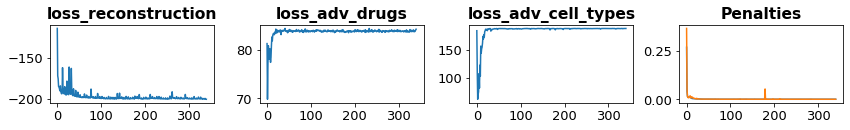

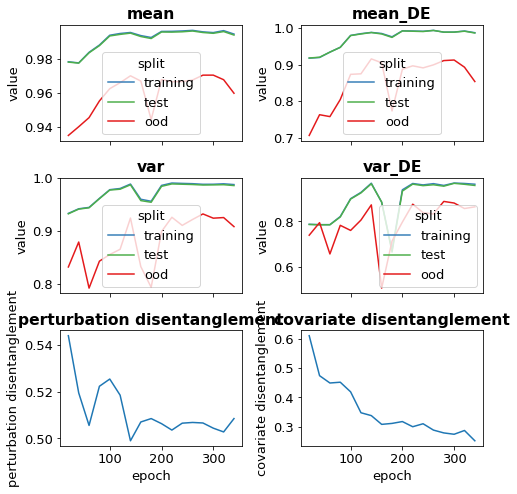

In [6]:
pretty_history = ComPertHistory(history, fileprefix=plots_prefix)
pretty_history.print_time()
pretty_history.plot_losses()
pretty_history.plot_metrics(epoch_min=0)

In [7]:
datasets, full_dataset = load_dataset_splits(
    dataset_path=args["dataset_path"],
    perturbation_key=args["perturbation_key"],
    dose_key=args["dose_key"],
    cell_type_key=args["cell_type_key"],
    split_key=args['split_key'],
    return_dataset=True) 

In [8]:
compert_api = ComPertAPI(datasets, autoencoder)

In [9]:
compert_api.num_measured_points['training']

{'mouse_LPS_0.3333333333333333': 7114,
 'mouse_LPS_0.6666666666666666': 6398,
 'mouse_unst_1.0': 5952,
 'pig_LPS_0.3333333333333333': 3797,
 'pig_LPS_0.6666666666666666': 4573,
 'pig_LPS_1.0': 3568,
 'pig_unst_1.0': 4166,
 'rabbit_LPS_0.3333333333333333': 6131,
 'rabbit_LPS_0.6666666666666666': 4118,
 'rabbit_LPS_1.0': 4727,
 'rabbit_unst_1.0': 6050,
 'rat_LPS_0.3333333333333333': 4887,
 'rat_LPS_0.6666666666666666': 4040,
 'rat_unst_1.0': 4634}

In [10]:
perts_anndata = compert_api.get_drug_embeddings()
covars_anndata = compert_api.get_covars_embeddings()

In [11]:
compert_plots = CompertVisuals(compert_api, fileprefix=f"../paper_figures/figure2/{model_name.split('/')[-2]}")

Saved file to: ../paper_figures/figure2/cross_species_emebdding.png
Saved file to: ../paper_figures/figure2/cross_species_emebdding_similarity.png


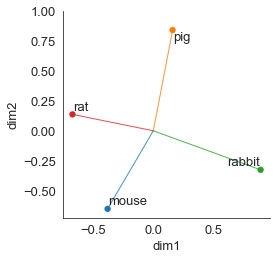

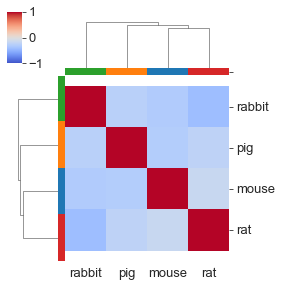

In [12]:
compert_plots.plot_latent_embeddings(compert_api.emb_covars, kind='covars', show_text=True, titlename='')

In [13]:
LPSi = np.where(np.array(compert_api.unique_perts) == 'LPS')[0][0]
emd_LPS = compert_api.emb_covars.copy()
LPSi

0

Saved file to: ../paper_figures/figure2/cross_species_emebdding.png
Saved file to: ../paper_figures/figure2/cross_species_emebdding_similarity.png


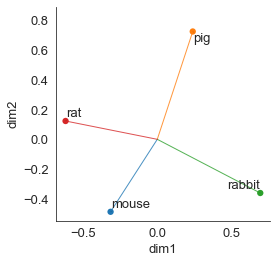

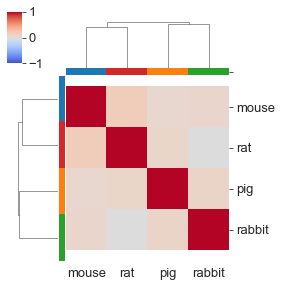

In [14]:
for i in range(len(emd_LPS)):
    emd_LPS[i] = compert_api.emb_covars[i].copy() + compert_api.emb_perts[LPSi]
compert_plots.plot_latent_embeddings(emd_LPS, kind='covars', show_text=True, titlename='', palette=compert_plots.сovars_palette,)

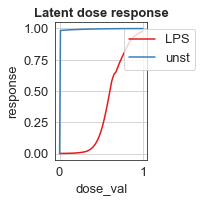

In [15]:
latent_response = compert_api.latent_dose_response()
compert_plots.plot_contvar_response(
    latent_response, 
    postfix='latent',
    var_name=compert_api.perturbation_key,
    figsize=(4, 3),
    bbox=(1.6, 1.),
    title_name='Latent dose response')

In [16]:
reconstructed_response = compert_api.get_response(datasets)

In [17]:
df_reference = compert_api.get_response_reference(datasets)

In [18]:
reconstructed_response['dose_val'] *= 6

In [19]:
df_reference['dose_val'] *= 6

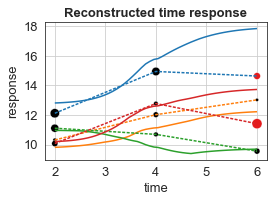

In [20]:
compert_plots.plot_contvar_response(
            reconstructed_response, 
            df_ref=df_reference, 
            postfix='reconstructed',
            title_name='Reconstructed time response', 
            figsize=(4, 3),
            bbox=(1.6, 1.),
            xlabelname='time',
            palette=compert_plots.сovars_palette,
            logdose=False)

In [21]:
tgt_genes = ['Car13', 'Chac1', 'Ncf1', 'Nfkbiz', 'Phlda1', 'Rel']

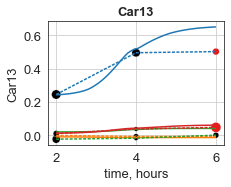

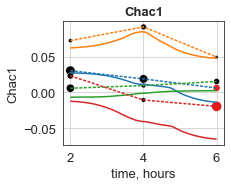

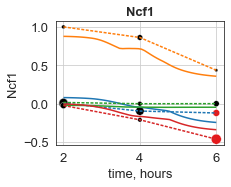

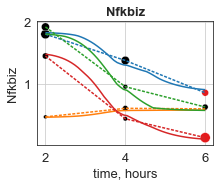

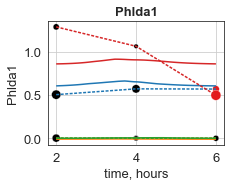

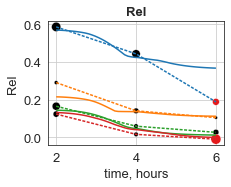

In [22]:
for gene in tgt_genes:
    compert_plots.plot_contvar_response(
            reconstructed_response, 
            df_ref=df_reference,
            xlabelname='time, hours',
            postfix=f'reconstructed_{gene}',
            response_name=gene,
            title_name=gene, 
            figsize=(3.4, 2.8),
            bbox=(1.6, 1.),
            palette=compert_plots.сovars_palette,
            logdose=False)

# Scores

In [23]:
genes_control = datasets['training_control'].genes
df_train = compert_api.evaluate_r2(datasets['training_treated'], genes_control)
df_train['benchmark'] = 'CPA'
df_train['split'] = 'train'

genes_control = datasets['test_control'].genes
df_test = compert_api.evaluate_r2(datasets['test_treated'], genes_control)
df_test['benchmark'] = 'CPA'
df_test['split'] = 'test'

genes_control = datasets['test_control'].genes
df_ood = compert_api.evaluate_r2(datasets['ood'], genes_control)
df_ood['benchmark'] = 'CPA'
df_ood['split'] = 'ood'

In [24]:
df_train

,cell_type,condition,dose_val,R2_mean,R2_mean_DE,R2_var,R2_var_DE,num_cells,benchmark,split
0,mouse,LPS,0.3333333333333333,0.997713,0.995473,0.993073,0.991417,7114,CPA,train
1,mouse,LPS,0.6666666666666666,0.997140,0.995147,0.991396,0.962723,6398,CPA,train
2,pig,LPS,0.3333333333333333,0.992101,0.979038,0.984885,0.955631,3797,CPA,train
3,pig,LPS,0.6666666666666666,0.994196,0.979579,0.988529,0.964148,4573,CPA,train
4,pig,LPS,1.0,0.994241,0.989586,0.990686,0.976985,3568,CPA,train
5,rabbit,LPS,0.3333333333333333,0.991647,0.994724,0.984328,0.933151,6131,CPA,train
6,rabbit,LPS,0.6666666666666666,0.989591,0.961567,0.978633,0.933952,4118,CPA,train
7,rabbit,LPS,1.0,0.995366,0.988800,0.989937,0.967821,4727,CPA,train
8,rat,LPS,0.3333333333333333,0.997421,0.996822,0.988081,0.970473,4887,CPA,train
9,rat,LPS,0.6666666666666666,0.997471,0.998669,0.993165,0.990573,4040,CPA,train


In [25]:
df_score = pd.concat([df_test, df_ood])
df_score['time'] = [float(d)*6 for d in df_score['dose_val'].values]
# df_score.round(2).sort_values(by=['cell_type', 'R2_mean', 'R2_mean_DE'], ascending=False)
df_score = df_score.round(2).sort_values(by=['cell_type', 'R2_mean', 'R2_mean_DE', 'R2_var'], ascending=False)

cols_print = ['cell_type', 'time','R2_mean', 'R2_mean_DE', 'R2_var', 'split', 'num_cells']
df_latex = df_score[cols_print].round(2).copy()
df_latex = df_latex.replace('ood', '\textbf{ood}')
print(df_latex.to_latex(index=False, bold_rows=True, escape=False))

\begin{tabular}{lrrrrlr}
\toprule
cell_type &  time &  R2_mean &  R2_mean_DE &  R2_var &        split &  num_cells \\
\midrule
      rat &   2.0 &     1.00 &        1.00 &    0.99 &         test &       2138 \\
      rat &   4.0 &     1.00 &        1.00 &    0.99 &         test &       1715 \\
      rat &   6.0 &     0.96 &        0.86 &    0.89 & \textbf{ood} &       7827 \\
   rabbit &   6.0 &     0.99 &        0.99 &    0.99 &         test &       2088 \\
   rabbit &   2.0 &     0.99 &        0.99 &    0.98 &         test &       2662 \\
   rabbit &   4.0 &     0.99 &        0.96 &    0.98 &         test &       1732 \\
      pig &   6.0 &     0.99 &        0.99 &    0.99 &         test &       1535 \\
      pig &   4.0 &     0.99 &        0.98 &    0.99 &         test &       1954 \\
      pig &   2.0 &     0.99 &        0.98 &    0.98 &         test &       1662 \\
    mouse &   2.0 &     1.00 &        0.99 &    0.99 &         test &       2904 \\
    mouse &   4.0 &     1.00 &   

# Uncertainty

../pretrained_models/cross_species/sweep_cross_species_new_split3_model_seed=8_epoch=160.pt
sweep_cross_species_new_split3_model_seed=8_epoch=160.pt
{'LPS': [0.3333333333333333, 0.6666666666666666], 'unst': [1.0]}


../compert/plotting.py:886: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


../pretrained_models/cross_species/sweep_cross_species_new_split1_model_seed=93_epoch=220.pt
sweep_cross_species_new_split1_model_seed=93_epoch=220.pt
{'LPS': [0.3333333333333333], 'unst': [1.0]}


../compert/plotting.py:886: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


../pretrained_models/cross_species/sweep_cross_species_new_split4_model_seed=39_epoch=340.pt
sweep_cross_species_new_split4_model_seed=39_epoch=340.pt
{'LPS': [0.6666666666666666], 'unst': [1.0]}


../compert/plotting.py:886: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


../pretrained_models/cross_species/sweep_cross_species_new_split2_model_seed=167_epoch=400.pt
sweep_cross_species_new_split2_model_seed=167_epoch=400.pt
{'LPS': [0.3333333333333333, 0.6666666666666666], 'unst': [1.0]}


../compert/plotting.py:886: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


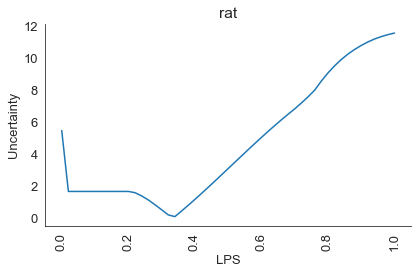

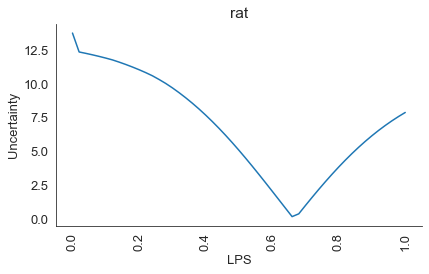

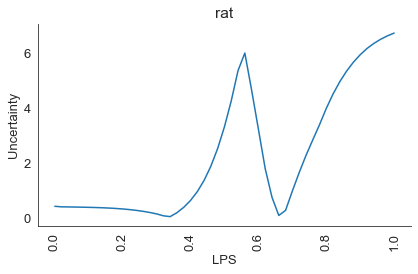

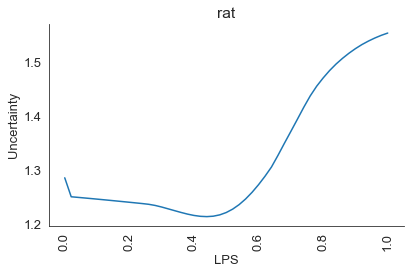

In [26]:
mypath = '../pretrained_models/'
_, folders, _ = next(walk(mypath))

i = 0
for fold in folders:
    for f in listdir(join(mypath, fold)):
        if ('cross' in f) and not ('deg_collect' in fold):            
            model_name = join(mypath, fold, f)
            print(model_name)
            split = model_name.split('/')[-1]
            print(split)
            print(compert_api.measured_points['training']['rat'])

            state, args, history = torch.load(model_name, map_location=torch.device('cpu'))
            args['dataset_path'] = '../datasets/cross_species_new.h5ad'
            autoencoder, datasets = prepare_compert(args, state_dict=state)
            compert_api = ComPertAPI(datasets, autoencoder)
            
            df_pred = pl.plot_uncertainty_dose(
                compert_api,
                cov='rat',
                pert='LPS',
                N=51,
            #     measured_points=,
                cond_key='condition',
                log=False,
                metric='eucl',
                filename=f'{compert_plots.fileprefix}_uncertainty_{split}.png',
            )         
            df_pred['time'] = [6*float(d) for d in df_pred['dose_val'].values]
            df_pred['model_name'] = model_name.split('/')[-1].split('_')[4] 
            
            if i == 0:
                df_uncert = df_pred
            else:
                df_uncert = pd.concat([df_uncert, df_pred])
            i += 1
            


In [27]:
df_uncert = df_uncert.replace('model', 'split0')

In [28]:
df_uncert.head()

,cell_type,condition,dose_val,uncertainty_cosine,uncertainty_eucl,closest_cond_cos,closest_cond_eucl,time,model_name
0,rat,LPS,0.0,0.036512,5.489451,rat_LPS_0.3333333333333333,rat_LPS_0.3333333333333333,0.00,split3
1,rat,LPS,0.02,0.003395,1.684956,rat_LPS_0.3333333333333333,rat_LPS_0.3333333333333333,0.12,split3
2,rat,LPS,0.04,0.003395,1.684956,rat_LPS_0.3333333333333333,rat_LPS_0.3333333333333333,0.24,split3
3,rat,LPS,0.06,0.003395,1.684956,rat_LPS_0.3333333333333333,rat_LPS_0.3333333333333333,0.36,split3
4,rat,LPS,0.08,0.003395,1.684956,rat_LPS_0.3333333333333333,rat_LPS_0.3333333333333333,0.48,split3


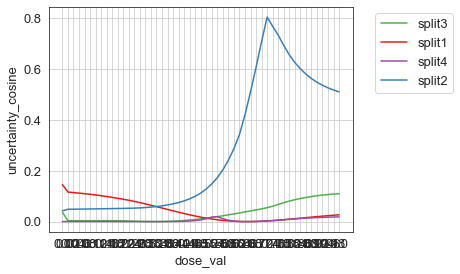

In [29]:
compert_plots.plot_contvar_response(
    df_uncert, 
    df_ref=None,
    var_name='model_name',
    response_name='uncertainty_cosine',
    postfix='uncertainty_cosine',
    logdose=False,
    title_name='')

# Compare various splits

In [30]:
mypath = '../pretrained_models/'
_, folders, _ = next(walk(mypath))
i = 0
for fold in folders:
    for f in listdir(join(mypath, fold)):
        if ('cross' in f) and not ('deg_collect' in fold):            
            model_name = join(mypath, fold, f)
            print(model_name)
            state, args, history = torch.load(model_name, map_location=torch.device('cpu'))
            args['dataset_path'] = '../datasets/cross_species_new.h5ad'
            autoencoder, datasets = prepare_compert(args, state_dict=state)
            compert_api = ComPertAPI(datasets, autoencoder)
            df_ood_splits = compert_api.evaluate_r2(datasets['ood'], datasets['training_control'].genes)
            df_ood_splits['split'] = 'ood'
            df_ood_splits['model_name'] = model_name.split('/')[-1]
            print(df_ood_splits)
            if i == 0:
                df = df_ood_splits
            else:
                df = pd.concat([df, df_ood_splits])
            i += 1

../pretrained_models/cross_species/sweep_cross_species_new_split3_model_seed=8_epoch=160.pt
  cell_type condition            dose_val   R2_mean  R2_mean_DE    R2_var  \
0       rat       LPS  0.6666666666666666  0.945520    0.796210  0.804801   
1       rat       LPS                 1.0  0.892128    0.704527  0.721250   

   R2_var_DE num_cells split  \
0   0.537955      5755   ood   
1   0.546258      7827   ood   

                                          model_name  
0  sweep_cross_species_new_split3_model_seed=8_ep...  
1  sweep_cross_species_new_split3_model_seed=8_ep...  
../pretrained_models/cross_species/sweep_cross_species_new_split1_model_seed=93_epoch=220.pt
  cell_type condition            dose_val   R2_mean  R2_mean_DE    R2_var  \
0       rat       LPS  0.3333333333333333  0.964088    0.900693  0.899554   
1       rat       LPS                 1.0  0.968885    0.905349  0.916345   

   R2_var_DE num_cells split  \
0   0.731563      7025   ood   
1   0.791014      7827   

In [31]:
df['split_name'] = [mn.split('_')[4] for mn in df['model_name'].values]

In [32]:
df['time'] = [6*float(d) for d in df['dose_val'].values]

In [33]:
df['left_out'] = [df['cell_type'].values[i] + '_' + str(6*float(df['dose_val'].values[i])) for i in range(len(df['dose_val']))]

In [34]:
split_name = df['split_name'].values
split_name[split_name == 'model'] = 'split0'
df['split_name'] = split_name


In [35]:
df.head()

,cell_type,condition,dose_val,R2_mean,R2_mean_DE,R2_var,R2_var_DE,num_cells,split,model_name,split_name,time,left_out
0,rat,LPS,0.6666666666666666,0.945520,0.796210,0.804801,0.537955,5755,ood,sweep_cross_species_new_split3_model_seed=8_ep...,split3,4.0,rat_4.0
1,rat,LPS,1.0,0.892128,0.704527,0.721250,0.546258,7827,ood,sweep_cross_species_new_split3_model_seed=8_ep...,split3,6.0,rat_6.0
0,rat,LPS,0.3333333333333333,0.964088,0.900693,0.899554,0.731563,7025,ood,sweep_cross_species_new_split1_model_seed=93_e...,split1,2.0,rat_2.0
1,rat,LPS,1.0,0.968885,0.905349,0.916345,0.791014,7827,ood,sweep_cross_species_new_split1_model_seed=93_e...,split1,6.0,rat_6.0
0,mouse,LPS,1.0,0.960968,0.847888,0.931614,0.902247,5280,ood,sweep_cross_species_new_split4_model_seed=39_e...,split4,6.0,mouse_6.0


In [36]:
df = df.round(2).sort_values(by=['split_name', 'cell_type', 'time','R2_mean', 'R2_mean_DE', 'R2_var'], ascending=False)

cols_print = ['split_name', 'cell_type', 'time','R2_mean', 'R2_mean_DE', 'R2_var', 'num_cells']
df_latex = df[cols_print].round(2).copy()
df_latex = df_latex.replace('ood', '\textbf{ood}')
df_latex = df_latex.replace('split4', 'split')
print(df_latex.to_latex(index=False, bold_rows=True, escape=False))

\begin{tabular}{llrrrrr}
\toprule
split_name & cell_type &  time &  R2_mean &  R2_mean_DE &  R2_var &  num_cells \\
\midrule
     split &       rat &   6.0 &     0.96 &        0.86 &    0.89 &       7827 \\
     split &     mouse &   6.0 &     0.96 &        0.85 &    0.93 &       5280 \\
    split3 &       rat &   6.0 &     0.89 &        0.70 &    0.72 &       7827 \\
    split3 &       rat &   4.0 &     0.95 &        0.80 &    0.80 &       5755 \\
    split2 &       rat &   6.0 &     0.54 &        0.02 &    0.02 &       7827 \\
    split2 &       rat &   4.0 &     0.39 &       -0.85 &   -0.47 &       5755 \\
    split2 &       rat &   2.0 &     0.41 &       -0.96 &   -0.64 &       7025 \\
    split1 &       rat &   6.0 &     0.97 &        0.91 &    0.92 &       7827 \\
    split1 &       rat &   2.0 &     0.96 &        0.90 &    0.90 &       7025 \\
\bottomrule
\end{tabular}



In [37]:
df['left_out'] = [f"{s.split('_')[0]}, {float(s.split('_')[1]):.0f}h" for s in df['left_out'].values]

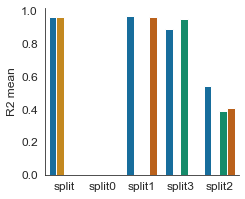

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
df = df.replace('split4', 'split')

fontsize=12
figsize=(4.5, 6)
# fig = plt.figure(figsize=figsize)
# ax = plt.gca()
ax = sns.catplot(
    data=df, kind="bar",
    order=['split', 'split0', 'split1', 'split3', 'split2'], 
    x="split_name", y="R2_mean", hue="left_out",
    ci="sd", palette="colorblind", height=3, aspect=4./3.5, legend_out=False
)
plt.title('', fontsize=fontsize, fontweight="bold")
# plt.setp(ax._legend.get_title(), fontsize=fontsize)
# plt.setp(ax._legend.get_texts(), fontsize=fontsize)

ax = plt.gca()
ax.legend_.remove()

ax.xaxis.set_tick_params(labelsize=fontsize)
ax.yaxis.set_tick_params(labelsize=fontsize)
ax.set_xlabel('', fontsize=fontsize)
ax.set_ylabel('R2 mean', fontsize=fontsize)

# plt.tight_layout()
plt.savefig(f'../paper_figures/figure2/cs_benchmark.png', format='png')

In [39]:
import numpy as np
np.unique(df_uncert['model_name'])

array(['split1', 'split2', 'split3', 'split4'], dtype=object)

In [40]:
df_uncert['time'] = [float(dv)*6.0 for dv in df_uncert['dose_val'].values]

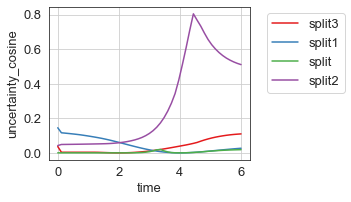

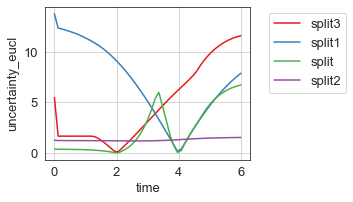

In [41]:
df_uncert = df_uncert.replace('split4', 'split')

for unc in ['uncertainty_cosine', 'uncertainty_eucl']:
    pl.plot_dose_response(df_uncert,
                           'time',
                           'model_name',
                           xlabelname='time',
                           df_ref=None,
                           response_name=unc,
                           title_name='',
                           use_ref_response=False,
                           col_dict="Set1",
                           plot_vertical=False,
                           f1=6,
                           f2=3,
                           measured_points=[2, 4, 6],
                           fname=f'../paper_figures/figure2/cs_{unc}',
                           bbox=(1.5, 1.),
                           fontsize=13,
                           format='png')


In [42]:
uncertainty = pd.DataFrame(columns=[compert_api.covars_key, 
                                        compert_api.perturbation_key, 
                                        compert_api.dose_key, 'cosine', 'euclidean', 'model_name', 'num_cells'])


mypath = '../pretrained_models/'
_, folders, _ = next(walk(mypath))

i = 0
for fold in folders:
    for f in listdir(join(mypath, fold)):
        if ('cross' in f) and not ('deg_collect' in fold):            
            model_name = join(mypath, fold, f)

            state, args, history = torch.load(model_name, map_location=torch.device('cpu'))
            args['dataset_path'] = '../datasets/cross_species_new.h5ad'
            autoencoder, datasets = prepare_compert(args, state_dict=state)
            compert_api = ComPertAPI(datasets, autoencoder)
            split = model_name.split('/')[-1].split('_')[4] 
            print(split)
            
            for pert in compert_api.seen_covars_perts['ood']:
                cov, drug, dose = pert.split('_')
                ncells = len(np.where(datasets['ood'].pert_categories == '_'.join([cov, drug, str(dose)]))[0])
                uncert_cos, uncert_eucl, _, _ = compert_api.compute_uncertainty(cov, drug, dose)
                uncertainty.loc[i] = [cov, drug, dose, uncert_cos, uncert_eucl, split, ncells]
                i+= 1


split3
split1
split4
split2


In [43]:
uncertainty['time'] = [float(dv)*6.0 for dv in uncertainty['dose_val'].values]
uncertainty = uncertainty.replace('model', 'split0')
uncertainty = uncertainty.replace('split4', 'split')

uncertainty['uncertainty_cosine'] = uncertainty['cosine'].values
uncertainty['uncertainty_eucl'] = uncertainty['euclidean'].values
uncertainty['split'] = uncertainty['model_name'].values

In [44]:
uncertainty['split'] = 'ood'

In [45]:
list_new = []
for split in np.unique(df_uncert['model_name']):
    list_new.append(df_uncert[df_uncert['model_name'] == split].copy())

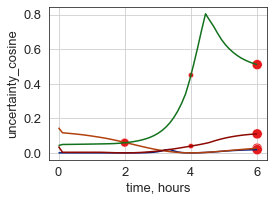

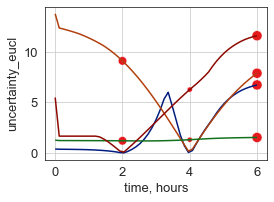

In [46]:
for unc in ['uncertainty_cosine', 'uncertainty_eucl']:
    pl.plot_dose_response(pd.concat(list_new),
                           'time',
                           'model_name',
                           xlabelname='time, hours',
                           df_ref=uncertainty,
                           response_name=unc,
                           title_name='',
                           use_ref_response=True,
                           interpolate=False,
                           col_dict='dark',
                           plot_vertical=False,
                           f1=4,
                           f2=3,
                           measured_points=[2, 4, 6],
                           fname=f'../paper_figures/figure2/cs_{unc}',
                           bbox=(1.5, 1.),
                           fontsize=13,
                           format='png')


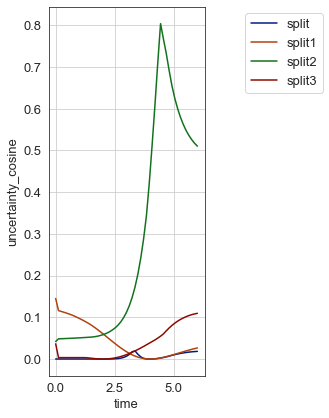

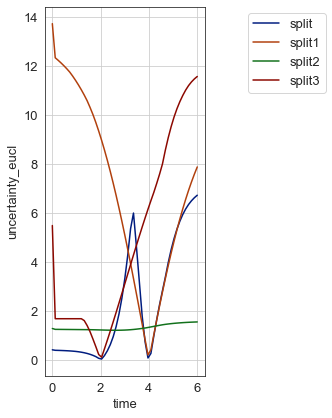

In [47]:
for unc in ['uncertainty_cosine', 'uncertainty_eucl']:
    pl.plot_dose_response(pd.concat(list_new),
                           'time',
                           'model_name',
                           xlabelname='time',
                           df_ref=None,
                           response_name=unc,
                           title_name='',
                           use_ref_response=False,
                           col_dict='dark',
                           plot_vertical=False,
                           f1=8,
                           f2=6,
                           fname=f'../paper_figures/figure2/cs_{unc}_leg',
                           bbox=(1.8, 1.),
                           fontsize=13,
                           format='png')


In [48]:
uncertainty

,cell_type,condition,dose_val,cosine,euclidean,model_name,num_cells,time,uncertainty_cosine,uncertainty_eucl,split,origin
0,rat,LPS,0.6666666666666666,0.039165,6.270547,split3,5755,4.0,0.039165,6.270547,ood,observations
1,rat,LPS,1.0,0.109611,11.573167,split3,7827,6.0,0.109611,11.573167,ood,observations
2,rat,LPS,0.3333333333333333,0.060510,9.095887,split1,7025,2.0,0.060510,9.095887,ood,observations
3,rat,LPS,1.0,0.026648,7.880058,split1,7827,6.0,0.026648,7.880058,ood,observations
4,mouse,LPS,1.0,0.013392,6.726491,split,5280,6.0,0.013392,6.726491,ood,observations
5,rat,LPS,1.0,0.018402,6.726491,split,7827,6.0,0.018402,6.726491,ood,observations
6,rat,LPS,0.3333333333333333,0.058334,1.226156,split2,7025,2.0,0.058334,1.226156,ood,observations
7,rat,LPS,0.6666666666666666,0.449361,1.334505,split2,5755,4.0,0.449361,1.334505,ood,observations
8,rat,LPS,1.0,0.510364,1.553508,split2,7827,6.0,0.510364,1.553508,ood,observations
